In [1]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline 
import math

In [2]:
from sklearn import preprocessing 
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
Y = df['quality'].values
le = preprocessing.LabelEncoder().fit(Y)
Y = le.transform(Y)
df = preprocessing.scale(df.drop('quality',1))
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(df, Y, test_size = .80, random_state=42)

In [3]:
from keras.datasets import mnist
(train_img, y_train), (val_img, y_test) = mnist.load_data()
x_train = np.array([train_img[i].flatten() for i in xrange(len(train_img))])/float(255)
x_test = np.array([val_img[i].flatten() for i in xrange(len(val_img))])/float(255)

Using TensorFlow backend.


In [4]:
class Topology:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)

class Dense:
    def __init__(self, input_shape, output_shape, n_hidden):
        self.n_hidden = n_hidden
        self.weights = np.random.randn(input_shape, output_shape) * .1
        self.moment1 = np.zeros((input_shape, output_shape))
        self.moment2 = np.zeros((input_shape, output_shape))
        self.gradients = []
        self.deltas = []
        self.hidden_layer = None
        self.delta = None
        self.layer_type = 'Dense'
        
    def forward(self, forward_data):
        self.hidden_layer = np.matmul(forward_data, self.weights)
        return self.hidden_layer
    
    def prev_delta(self, delta):
        delta = np.matmul(delta, (self.weights).T)
        self.deltas.append(delta)
        return delta
    
    def compute_gradient(self, backward_data, delta):
        gradient = np.matmul(backward_data.T, delta)
        self.gradients.append(gradient)
        return gradient


class Convolution2D:
    def __init__(self, num_filters, num_channels, filter_shape, img_shape):
        self.filter_shape = filter_shape
        self.num_channels = num_channels
        self.img_shape = img_shape
        self.num_filters = num_filters
        self.weights = self.init_conv_parameters(num_filters, num_channels, (filter_shape[0], filter_shape[1]), 'weights')
        self.moment1 = self.init_conv_parameters(num_filters, num_channels, (filter_shape[0], filter_shape[1]), 'moment')
        self.moment2 = self.init_conv_parameters(num_filters, num_channels, (filter_shape[0], filter_shape[1]), 'moment')
        self.gradients = []
        self.deltas = []
        self.delta = None
        self.layer_type = 'Convolution2D'
        
    def init_conv_parameters(self, num_filters, num_channels, filter_shape, kind):
        l1 = []
        for i in xrange(num_filters):
            l2 = []
            for j in xrange(num_channels):
                if kind == 'weights':
                    l2.append(np.random.randn(filter_shape[0], filter_shape[1]) * .1)
                if kind == 'moment':
                    l2.append(np.zeros((filter_shape[0], filter_shape[1])))
            l1.append(l2)
        return np.array(l1)
        
    def img2col(self, matrix, filter_size):
        col_extent = matrix.shape[1]-filter_size[1] + 1
        row_extent = matrix.shape[0]-filter_size[0] + 1
        start_idx = np.arange(filter_size[0])[:, None]*matrix.shape[1] + np.arange(filter_size[1])
        offset_idx = np.arange(row_extent)[:,None]*matrix.shape[0] + np.arange(col_extent)
        out = np.take(matrix, start_idx.ravel()[:,None] + offset_idx.ravel())
        return out.T

    def convolution(self, img, fil, padding):
        padded = np.pad(img, padding, 'constant', constant_values=0)
        convolved = np.matmul(self.img2col(padded, fil.shape), fil.flatten()).reshape(padded.shape[0]-fil.shape[0]+1, padded.shape[1]-fil.shape[1]+1)
        if np.max(convolved) > 100:
            print np.max(convolved)
        if np.min(convolved) < -100:
            print np.min(convolved)
        return convolved

    def forward(self, forward_data):
        batch_size = len(forward_data)
        forward_data = forward_data.reshape(batch_size, self.num_channels, self.img_shape[0], self.img_shape[1])
        outputs = []
        for img in forward_data:
            channels = []
            for channel in xrange(self.num_channels):
                img_flat = []
                for fil in self.weights[:, channel]:
                    output = self.convolution(img[channel].reshape(self.img_shape[0], self.img_shape[1]), fil, padding=self.filter_shape[0]/2)
                    img_flat.append(output.flatten())
                channels.append(img_flat)
            outputs.append(np.array(channels).flatten())
        conv_output = np.array(outputs).reshape(len(forward_data), self.num_channels*self.num_filters*self.img_shape[0]*self.img_shape[1], order='C')
        return conv_output
    
    def compute_gradient(self, backward_data, delta):
        batch_size = len(backward_data)
        delta = delta.reshape(batch_size, self.num_filters, self.num_channels, self.img_shape[0], self.img_shape[1], order='C')

        backward_data = backward_data.reshape(batch_size, self.num_channels, self.img_shape[0], self.img_shape[1])
        
        conv_gradients = []
        for img_index in xrange(batch_size):
            per_filter = []
            for fil_index in xrange(self.num_filters):
                per_channel = []
                for channel in xrange(self.num_channels):
                    output = self.convolution(backward_data[img_index][channel], delta[img_index][fil_index][channel], padding=(self.filter_shape[0]/2))
                    per_channel.append(output)
                per_filter.append(per_channel)
            conv_gradients.append(np.array(per_filter))
        conv_gradients = np.array(conv_gradients)
        
        avg_gradients = []
        for filter_index in xrange(conv_gradients.shape[1]):
            channel_avg = []
            for channel_index in xrange(self.num_channels):
                avg = np.zeros(self.filter_shape)
                for datapoint_index in xrange(conv_gradients.shape[0]):
                    avg = avg + conv_gradients[datapoint_index][filter_index][channel_index]
                avg = avg/float(batch_size)
                channel_avg.append(avg)
            avg_gradients.append(np.array(channel_avg))
        avg_gradients = np.array(avg_gradients)
        self.gradients.append(avg_gradients)
        return avg_gradients

    def prev_delta(self, delta):
        batch_size = delta.shape[0]
        delta = delta.reshape(batch_size, self.num_filters, self.num_channels, self.img_shape[0], self.img_shape[1], order='C')

        per_img = []
        for img_index in xrange(batch_size):
            filter_deltas = []
            for channel in xrange(self.num_channels):
                avg = np.zeros(self.img_shape)
                for fil in xrange(self.num_filters):
                    kernel = np.fliplr(np.flipud(self.weights[fil][channel]))
                    output = self.convolution(delta[img_index][fil][channel], kernel, padding=(self.filter_shape[0]/2))
                    avg += output
                filter_deltas.append(avg/self.num_filters)
            per_img.append(np.array(filter_deltas).flatten())
        per_img = np.array(per_img)
        self.deltas.append(per_img)
        return per_img
    
class Activation:
    def __init__(self, kind):
        self.layer_type = 'Activation'
        self.kind = kind
        self.hidden_layer = None
        self.delta = None
        self.output_softmax = None
        self.deltas = []
        
    def forward(self, input_data):
        if self.kind == 'relu':
            self.hidden_layer = np.maximum(0, input_data)
            return self.hidden_layer
        
        if self.kind == 'linear':
            self.hidden_layer = input_data
            return self.hidden_layer
        
        if self.kind == 'softmax':
            # Deal with Overflow Problems
            input_data = input_data - np.amax(input_data, axis=1, keepdims=True)
            # Compute Softmax
            self.hidden_layer = np.exp(input_data)
            self.output_softmax = self.hidden_layer / np.sum(self.hidden_layer, axis=1, keepdims=True)
            return self.output_softmax
        
    def prev_delta(self, delta):
        if self.kind == 'relu':
            delta[self.hidden_layer <= 0] = 0
            self.deltas.append(delta)
            return delta
        
        if self.kind == 'linear':
            self.deltas.append(delta)
            return delta
        
        if self.kind == 'softmax':
            self.output_softmax /= len(self.output_softmax)
            self.output_softmax[range(batch_size), y_batch] -= 1
            self.deltas.append(output_softmax)
            self.delta = self.output_softmax
            return self.delta
        
    def compute_gradient(self, fill1, fill2):
        return
    
def evaluate(t, x_test, y_test):
    x = x_test
    # Forward
    for layer in t.layers:
        x = layer.forward(x)    
    output_softmax = x
    loss = Counter(y_test-np.argmax(output_softmax, axis=1))[0]/float(len(y_test))
    return loss

In [19]:
def neural_network(x_train, y_train, x_test, y_test, t, lr=0.1, s=0.9, r=0.999, num_iters=10000, batch_size=32, optimizer='adam'):
    
    # Get Important Shapes
    n_row, n_col = np.shape(x_train)
    n_classes = len(np.unique(y_train))
    
    # Init Space for Losses
    losses = []
    
    # Init time step
    step = 0
    
    # Init numerical stability
    numerical_stability = .0000001
    
    # Iterate Through Backpropagation
    for iteration in xrange(num_iters):
        step += 1
        
        stochastic_sample = np.random.randint(0, n_row-1, batch_size)
            
        x_batch = x_train[stochastic_sample]
        y_batch = y_train[stochastic_sample]
        
        x = x_batch
        # Forward
        for layer in t.layers:
            x = layer.forward(x)
        
        output_softmax = x
        
        # Backward
        output_softmax[range(batch_size), y_batch] -= 1
        t.layers[-1].delta = output_softmax/batch_size
        
        # Compute Errors
        for i in xrange(len(t.layers)-2, 0, -1):
            t.layers[i].delta = t.layers[i].prev_delta(t.layers[i+1].delta)
        
        # Compute and Update Gradients
        for i in xrange(len(t.layers)-2, -1, -1):
            if t.layers[i].layer_type == 'Dense' or t.layers[i].layer_type == 'Convolution2D':
                if t.layers[i].layer_type == 'Dense':
                    if i == 0:
                        gradient = t.layers[i].compute_gradient(x_batch, t.layers[i+1].delta)
                    else:
                        gradient = t.layers[i].compute_gradient(t.layers[i-1].hidden_layer, t.layers[i+1].delta)

                if t.layers[i].layer_type == 'Convolution2D':
                    if i == 0:
                        gradient = t.layers[i].compute_gradient(x_batch, t.layers[i+1].delta)
                    else:
                        gradient = t.layers[i].compute_gradient(t.layers[i-1].hidden_layer, t.layers[i+1].delta)


                if optimizer == 'adam':
                    
                    gradient = gradient + numerical_stability

                    # Update biased moment estimates
                    t.layers[i].moment1 = s * t.layers[i].moment1 + (1-s) * gradient
                    t.layers[i].moment2 = r * t.layers[i].moment2 + (1-r) * (gradient * gradient)

                    # Correct bias in moment estimates
                    m1_unbiased = t.layers[i].moment1/(1-s**step)
                    m2_unbiased = t.layers[i].moment2/(1-r**step)

                    # Update Layer Weights
                    t.layers[i].weights -= lr * m1_unbiased/(np.sqrt(m2_unbiased) + numerical_stability)

                if optimizer == 'sgd':

                    # Update Layer Weights
                    t.layers[i].weights -= lr * gradient

                if optimizer == 'momentum':

                    # Update Momentum
                    t.layers[i].moment1 = s * t.layers[i].moment1 + (1-s) * gradient

                    # Update Layer Weights
                    t.layers[i].weights -= (lr * gradient) + t.layers[i].moment1      
        
        if iteration % 10 == 0:
            training_loss = evaluate(t, x_train[:1000], y_train[:1000])
            validation_loss = evaluate(t, x_test[:1000], y_test[:1000])
            losses.append([training_loss, validation_loss])
        if iteration % 100 == 0:
            print "Iteration ", iteration, ": Train Loss = ", training_loss, " Val Loss = ", validation_loss
        
    return t, losses

In [20]:
t = Topology()
t.add(Dense(x_train.shape[1], 1000, 1000))
t.add(Activation('relu'))
t.add(Dense(1000, len(np.unique(y_train)), 0))
t.add(Activation('softmax'))
topology, l = neural_network(x_train, y_train, x_test, y_test, t, lr=.01, num_iters = 1000, optimizer='adam')

Iteration  0 : Train Loss =  0.339  Val Loss =  0.326
Iteration  100 : Train Loss =  0.896  Val Loss =  0.904
Iteration  200 : Train Loss =  0.902  Val Loss =  0.913
Iteration  300 : Train Loss =  0.929  Val Loss =  0.93
Iteration  400 : Train Loss =  0.907  Val Loss =  0.911
Iteration  500 : Train Loss =  0.937  Val Loss =  0.923
Iteration  600 : Train Loss =  0.923  Val Loss =  0.924
Iteration  700 : Train Loss =  0.924  Val Loss =  0.93
Iteration  800 : Train Loss =  0.938  Val Loss =  0.94
Iteration  900 : Train Loss =  0.941  Val Loss =  0.937


In [23]:
t = Topology()
t.add(Convolution2D(8, 1, (3,3), (28, 28)))
t.add(Activation('relu'))
t.add(Dense(6272, len(np.unique(y_train)), 0))
t.add(Activation('softmax'))
topology, l = neural_network(x_train, y_train, x_test, y_test, t, lr=.001, num_iters = 1000, optimizer='adam')

Iteration  0 : Train Loss =  0.106  Val Loss =  0.088
Iteration  100 : Train Loss =  0.832  Val Loss =  0.839
Iteration  200 : Train Loss =  0.88  Val Loss =  0.882
Iteration  300 : Train Loss =  0.896  Val Loss =  0.881
Iteration  400 : Train Loss =  0.897  Val Loss =  0.901
Iteration  500 : Train Loss =  0.918  Val Loss =  0.906
Iteration  600 : Train Loss =  0.924  Val Loss =  0.919
Iteration  700 : Train Loss =  0.927  Val Loss =  0.913
Iteration  800 : Train Loss =  0.926  Val Loss =  0.916
Iteration  900 : Train Loss =  0.937  Val Loss =  0.926


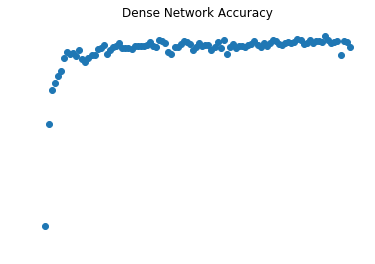

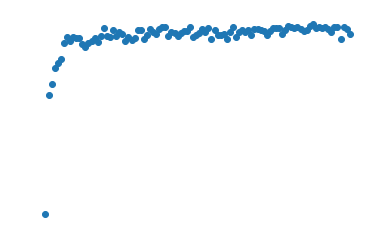

In [22]:
plt.scatter(np.arange(len(l)), np.array(l)[:,0])
plt.title("Dense Network Accuracy")
plt.show()
plt.scatter(np.arange(len(l)), np.array(l)[:,1])
plt.show()

In [ ]:
plt.scatter(np.arange(len(l)), np.array(l)[:,0])
plt.title("Convolutional Network Accuracy")
plt.show()
plt.scatter(np.arange(len(l)), np.array(l)[:,1])
plt.show()

In [ ]:
num_vis = 1000
plt.scatter(np.arange(num_vis), np.array(l[:num_vis])[:,0])
plt.show()
plt.scatter(np.arange(num_vis), np.array(l[:num_vis])[:,1])
plt.show()

In [ ]:
def evaluate(t, x_test, y_test):
    x_test = np.column_stack((np.ones(len(x_test)), x_test))
    x = x_test
    # Forward
    for layer in t.layers:
        x = layer.forward(x)    
    output_softmax = x
    loss = Counter(y_test-np.argmax(output_softmax, axis=1))[0]/float(len(y_test))
    return loss